## Neural Networks Learning

In this exercise, you will implement the backpropagation algorithm for neural networks and apply it to the task of hand-written digit recognition.

In the previous exercise, you implemented feedforward propagation for neural networks and used it to predict handwritten digits with the weights we provided. 

In this exercise, you will implement the backpropagation algorithm to learn the parameters for the neural network.

In [53]:
import numpy as np
from scipy.io import loadmat  # this is the SciPy module that loads mat-files
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize
import scipy.optimize as opt
%matplotlib notebook

In [26]:
data = loadmat('./ex4/ex4data1.mat');

In [27]:
X = pd.DataFrame(data['X']); y = pd.DataFrame(data['y']);

In [28]:
def load_images(ax):
    for i in range(10):
        for j in range(10):
            random_img = np.array(X.iloc[np.random.randint(X.shape[0])])
            img = random_img.reshape((20,20), order='F');
            ax[i,j].imshow(img)
            ax[i,j].axis('off')

<IPython.core.display.Javascript object>


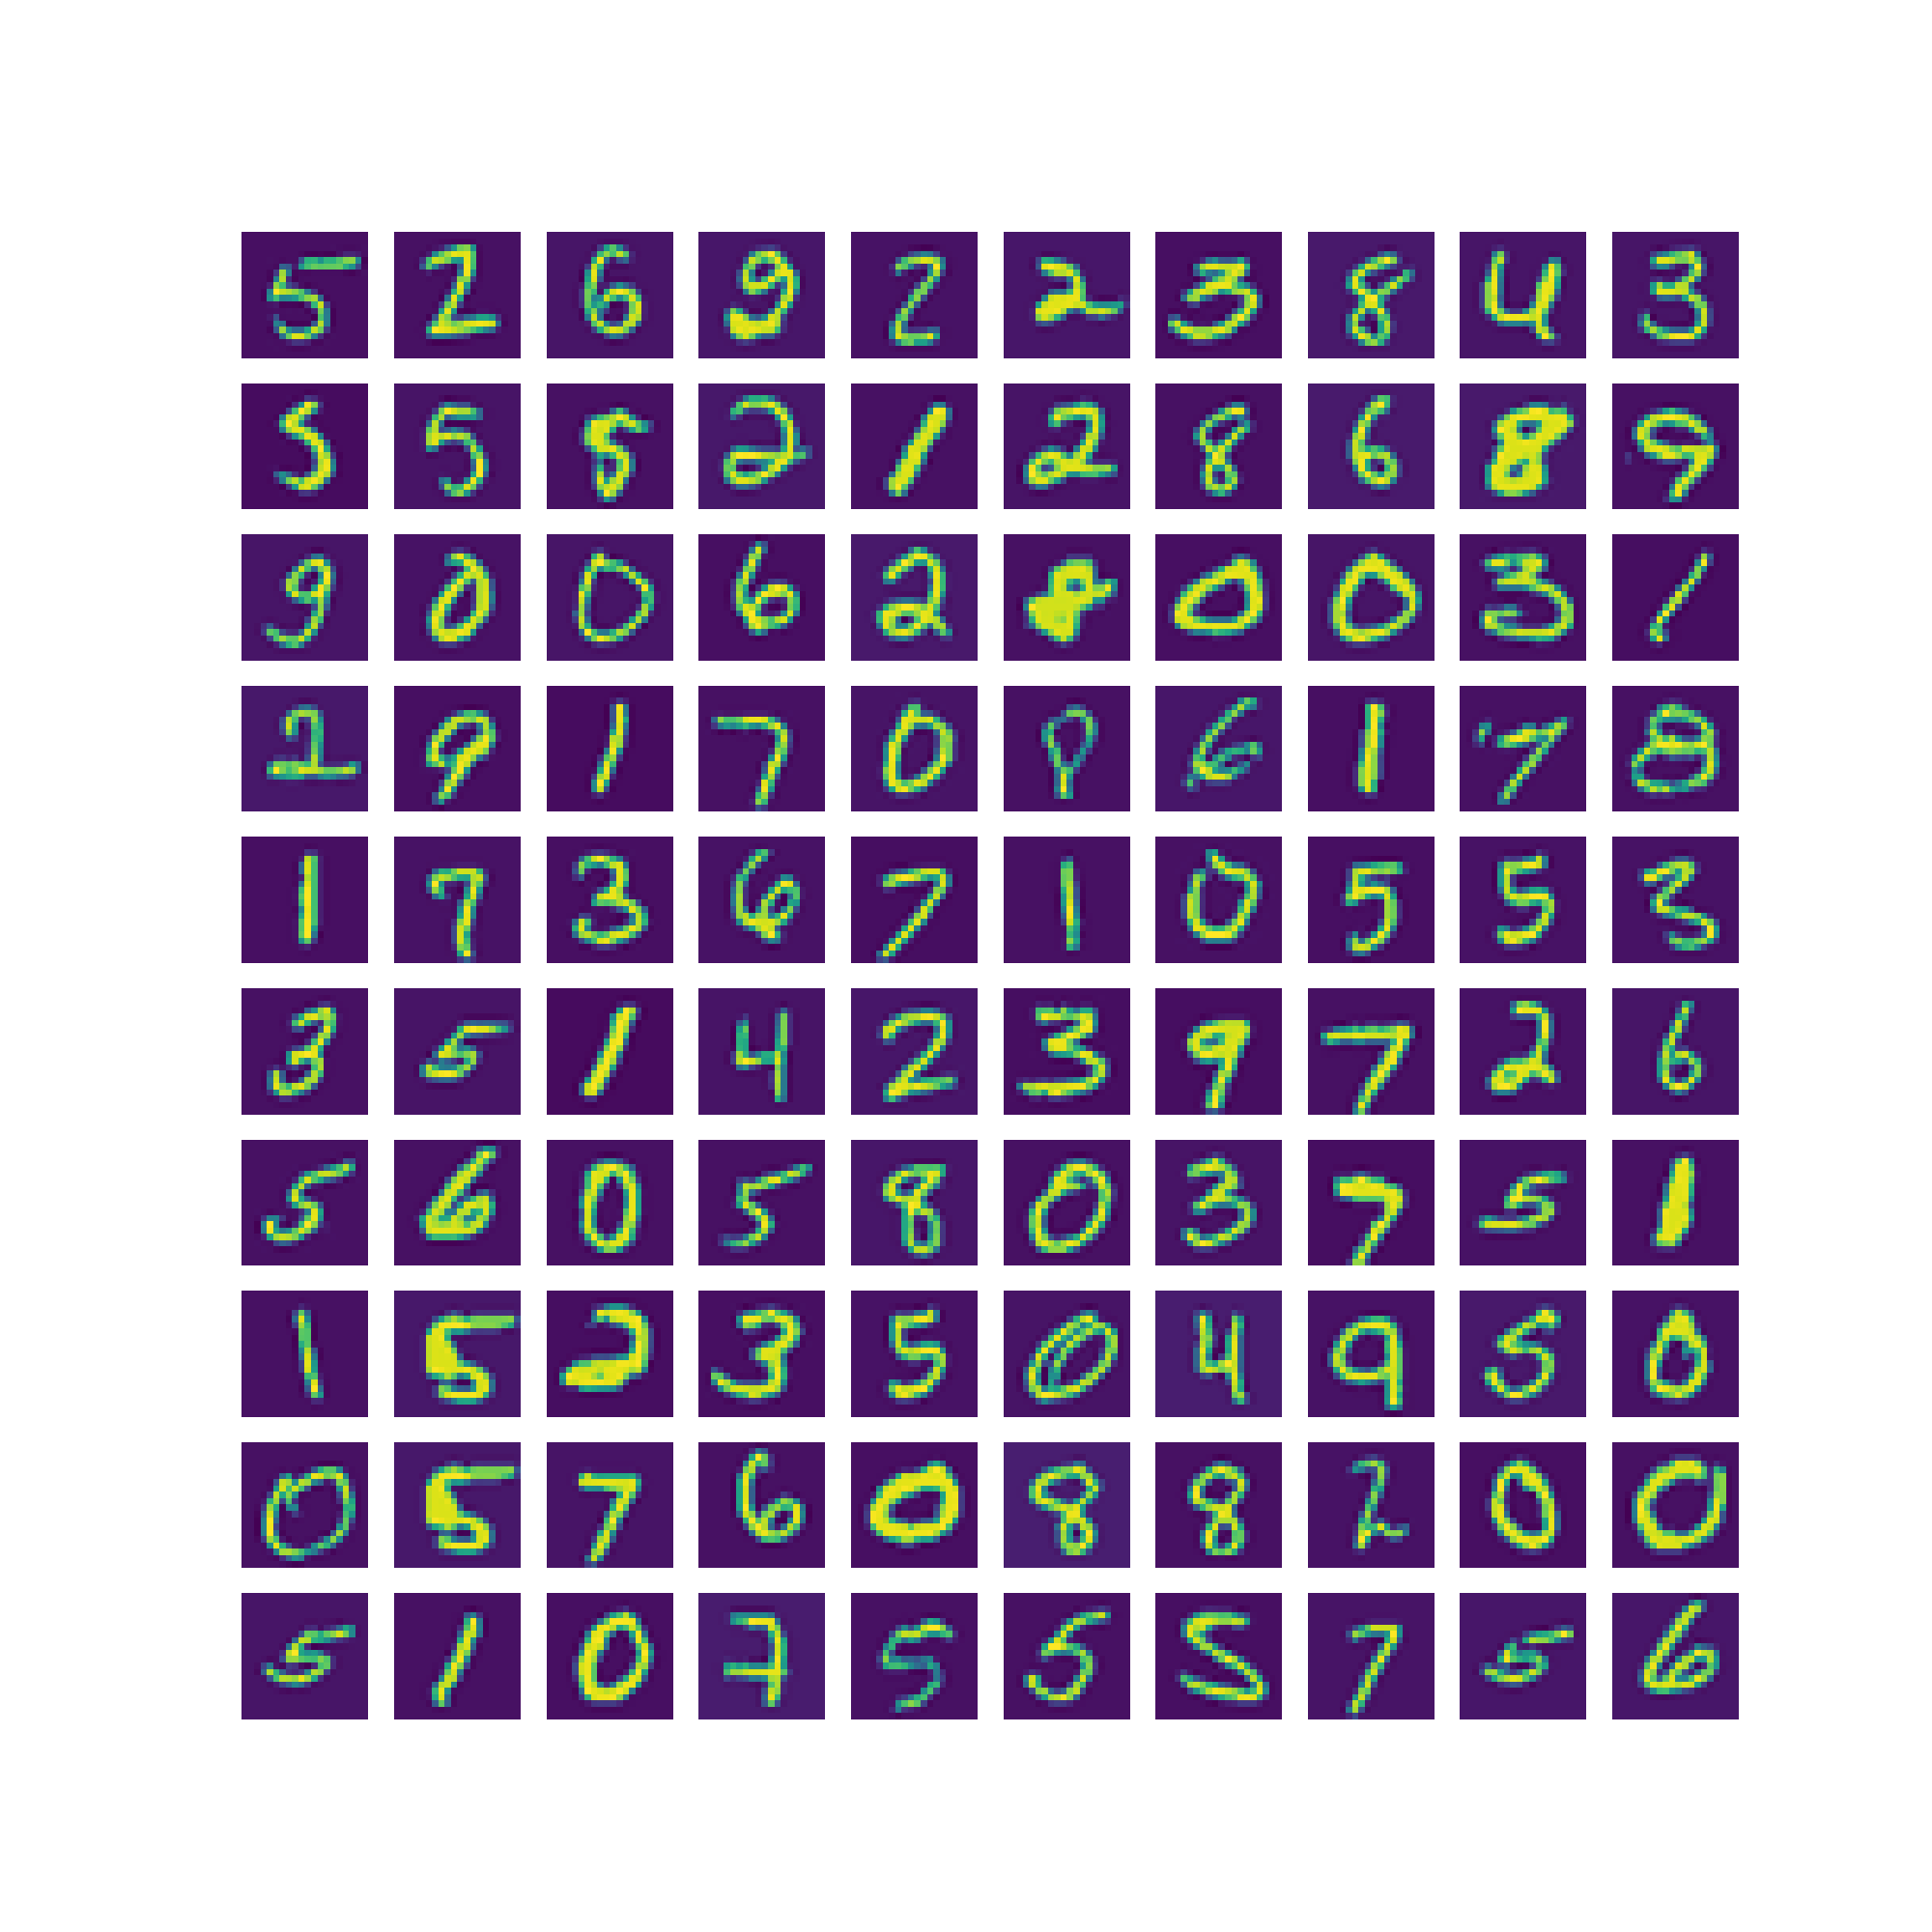

In [29]:
fig, ax = plt.subplots(10,10,figsize=(10,10));
load_images(ax);

In [9]:
weights = loadmat('./ex4/ex4weights.mat');

In [10]:
theta1, theta2 = weights['Theta1'], weights['Theta2']

In [32]:
print(f'Theta1 has size: {theta1.shape}')
print(f'Theta2 has size: {theta2.shape}')

Theta1 has size: (25, 401)
Theta2 has size: (10, 26)


### Feedforward and cost function

Part 1: Feedforward the neural network and return the cost in the variable J.

After implementing Part 1, you can verify that your cost function computation is correct by verifying the cost computed

In [14]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

In [15]:
def predict_nn(theta1, theta2, X):
    m = X.shape[0]
    X = np.hstack([np.ones((m,1)),X])
    a2 = sigmoid(theta1 @ X.T)
    a2 = np.vstack((np.ones((1,m)), a2)) # hidden layer
    a3 = sigmoid(theta2 @ a2)
    return a3.T
#     return np.argmax(a3, axis=0) + 1

In [16]:
def one_hot_encode(y, k):
    result = np.zeros((y.shape[0], k))
    for index, val in enumerate(y.values):
        row = np.zeros((1, k))
        row[0, val] = val
        result[index, :] = row
    return result

In [49]:
data = loadmat('ex4/ex4data1.mat')
X = data['X']
y = data['y']

In [86]:
import numpy as np

In [102]:
def nnCostFunc(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lmbda):
    eps = 1e-6
    theta1 = np.reshape(nn_params[:hidden_layer_size*(input_layer_size+1)], (hidden_layer_size, input_layer_size+1), 'F')
    theta2 = np.reshape(nn_params[hidden_layer_size*(input_layer_size+1):], (num_labels, hidden_layer_size+1), 'F')
    m = X.shape[0]
    h,_, _, _ = predict_nn(theta1, theta2, X) 
    y_d = pd.get_dummies(y.flatten())
    error = np.sum( + (1-y_d) * np.log(1-h))
    return np.sum(error/-m)

In [147]:
nn_params = np.hstack((theta1.ravel(order='F'), theta2.ravel(order='F'))) #unroll parameters

# neural network hyperparameters
input_layer_size = 400
hidden_layer_size = 25
num_labels = 10
lmbda = 1

In [104]:
J = nnCostFunc(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lmbda)

(5000, 10)


NameError: name 'error' is not defined

### Regularized Cost Function

In [105]:
def nnCostFuncReg(J, theta1, theta2, lmbda, m):
    theta1_sum = np.sum(np.sum(theta1[:,1:]**2, axis=1))
    theta2_sum = np.sum(np.sum(theta2[:,1:]**2, axis=1))
    reg_term = lmbda / (2*m) * (theta1_sum + theta2_sum)
    return J + reg_term
    

In [106]:
nnCostFuncReg(J, theta1, theta2, 1, 5000)

0.38376985909092354

## Backpropagation

### Sigmoid Gradient

In [107]:
def sigmoidGradient(z):
    return sigmoid(z) * (1 - sigmoid(z))

### Random Initialization

When training neural networks, it is important to randomly initialize the parameters for symmetry breaking. 

In [108]:
epsilon = 0.12; 

In [109]:
theta_range = np.arange(-epsilon, epsilon, 0.01)

In [110]:
np.random.uniform(1,3,3)

array([1.99050238, 1.37180151, 1.33865702])

In [111]:
def randInitializeWeights(L_in, L_out, epsilon):
    return np.random.rand(L_out, L_in +1) *(2*epsilon) - epsilon

In [112]:
# neural network hyperparameters
input_layer_size = 400
hidden_layer_size = 25
num_labels = 10
lmbda = 1

In [113]:
initial_theta1 = randInitializeWeights(input_layer_size, hidden_layer_size, 0.12)
initial_theta2 = randInitializeWeights(hidden_layer_size, num_labels, 0.12)

In [186]:
def predict_nn(theta1, theta2, X):
    m = X.shape[0]
    X = np.hstack([np.ones((m,1)),X])
    z2 = theta1 @ X.T
    a2 = sigmoid(z2)
    a2 = np.vstack((np.ones((1,m)), a2)) # hidden layer
    z3 = theta2 @ a2
    a3 = sigmoid(z3)
    return a3.T, a2.T, z3, z2

In [187]:
def nnCostFunc(nn_params, *args):
    input_layer_size = args[0]
    hidden_layer_size = args[1]
    num_labels = args[2]
    X, y, lmbda = args[3], args[4], args[5]

    theta1 = np.reshape(nn_params[:hidden_layer_size*(input_layer_size+1)], (hidden_layer_size, input_layer_size+1), 'F')
    theta2 = np.reshape(nn_params[hidden_layer_size*(input_layer_size+1):], (num_labels, hidden_layer_size+1), 'F')
    m = X.shape[0]
    h, _, _, _ = predict_nn(theta1, theta2, X)
    y_d = pd.get_dummies(y.flatten())
    
    error = np.sum((y_d * np.log(h)) + ((1-y_d) * np.log(1-h)))
    J = np.sum(error/-m)
    
    theta1_sum = np.sum(np.sum(theta1[:,1:]**2, axis=1))
    theta2_sum = np.sum(np.sum(theta2[:,1:]**2, axis=1))
    reg_term = lmbda / (2*m) * (theta1_sum + theta2_sum)
    return J + reg_term

In [188]:
def backprop(nn_params, *args):
    J = nnCostFunc(nn_params, *args)
    
    theta1 = np.reshape(nn_params[:hidden_layer_size*(input_layer_size+1)], (hidden_layer_size, input_layer_size+1), 'F')
    theta2 = np.reshape(nn_params[hidden_layer_size*(input_layer_size+1):], (num_labels, hidden_layer_size+1), 'F')
    
    m = X.shape[0]
    a3, a2, z3, z2 = predict_nn(theta1, theta2, X)
    a1 = X
    d3 = a3 - y # 5000 x 10
    d2 = d3 @ theta2[:, 1:] * sigmoidGradient(z2).T # 5000 x 25

#     print(f'd3 shape: {d3.shape}')
#     print(f'a2 shape: {a2.shape}')
#     print(f'd2 shape: {d2.shape}')
#     print(f'a1 shape: {a1.shape}')
    
    delta2 = (d3.T @ a2)[:, 1:] # 10 x 26
    delta1 = d2.T @ a1 # 25 x 400
    
#     print(f'delta2 shape: {delta2.shape}')
#     print(f'delta1 shape: {delta1.shape}')
    grad = np.concatenate((np.ravel(1/m * delta1), np.ravel(1/m * delta2)))
    return J, grad


In [190]:
J, grad = backprop(params, input_layer_size,hidden_layer_size,num_labels, X,y, lmbda);
J

6.572342152406177

### Gradient Checking

In [168]:
def create_nn_params(theta1, theta2):
    return np.hstack((theta1.ravel(order='F'), theta2.ravel(order='F'))) #unroll parameters


In [169]:
def computeNumericalGradient(params, epsilon):
    params_high = params + epsilon
    params_low = params - epsilon
    print(params_high.shape)
    
    J_h = nnCostFunc(params_high, input_layer_size, hidden_layer_size, num_labels, X, y, 1)
    J_l = nnCostFunc(params_low, input_layer_size, hidden_layer_size, num_labels, X, y, 1)
    
    return (J_h - J_l) / (2 * epsilon)
    